In [1]:
import open3d
import numpy as np
import pandas as pd
import os
import tqdm
import copy

import matplotlib.pyplot as plt
import utils.registration as registration
import utils.functions as functions
import utils.transform as transform
import utils.pointcloud as pointcloud
import utils.fread as fread
import utils.FCGF as FCGF

from utils.config import Config
from scipy.ndimage import gaussian_filter1d

In [2]:
config = Config(
    sequence_dir="data/raw_data",
    feature_dir="data/features",
    output_dir="data/trajectories/trajectory/IMU_PCD",
    experiment="exp_11",
    trial="trial_1",
    subject="subject-1",
    sequence="01",
    groundtruth_dir="data/trajectories/groundtruth",
)

config.voxel_size=0.03
config.target_fps=20
config.min_std=0.5

In [3]:
feature_dir = config.get_feature_dir()
motion_dir = config.get_motion_dir()

sequence_ts = fread.get_timstamps(feature_dir, ext=".secondary.npz")
sequence_ts = fread.sample_timestamps(sequence_ts, config.target_fps)

In [26]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)
imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000
win_len = int(frame_rate * 4) # 4 seconds window

In [27]:
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

sigma = 2
# apply gaussian filter to smooth acceleration and gyro data
imu_df.loc[:, "xa"] = gaussian_filter1d(imu_df.xa.values, sigma=sigma)
imu_df.loc[:, "ya"] = gaussian_filter1d(imu_df.ya.values, sigma=sigma)
imu_df.loc[:, "za"] = gaussian_filter1d(imu_df.za.values, sigma=sigma)
imu_df.loc[:, "xg"] = gaussian_filter1d(imu_df.xg.values, sigma=sigma)
imu_df.loc[:, "yg"] = gaussian_filter1d(imu_df.yg.values, sigma=sigma)
imu_df.loc[:, "zg"] = gaussian_filter1d(imu_df.zg.values, sigma=sigma)

In [28]:
# gravity vector calculation    
gravity = imu_df.iloc[:win_len, [1, 2, 3]].mean().values
# removing gravity
imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - gravity
# moving average filter        
# accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
# accel_mavg.fillna(0, inplace=True)
# imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg
# remove the stabilization data
imu_df = imu_df.iloc[win_len:].copy()

<AxesSubplot:title={'center':'Linear Acceleration (ms^-2)'}, xlabel='timestamp'>

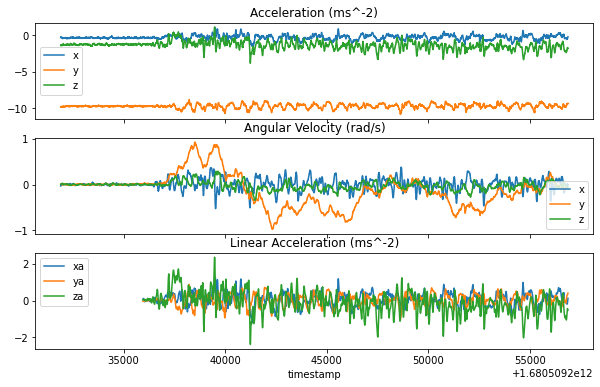

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

accel_df.plot(x="timestamp", y=["x", "y", "z"], ax=axs[0], title="Acceleration (ms^-2)")
gyro_df.plot(x="timestamp", y=["x", "y", "z"], ax=axs[1], title="Angular Velocity (rad/s)")
imu_df.plot(x="timestamp", y=["xa", "ya", "za"], ax=axs[2], title="Linear Acceleration (ms^-2)")

In [30]:
# load ground truth trajectory
start_t = np.where(sequence_ts == functions.nearest(sequence_ts, imu_df.timestamp.values[0]))[0][0]

In [31]:
sequence_ts = sequence_ts[start_t:]
num_frames = len(sequence_ts)

In [32]:
print("Number of frames: ", num_frames)

Number of frames:  369


In [33]:
local_pcds = []

for t in tqdm.trange(num_frames):
    feature_file = os.path.join(feature_dir, f"{sequence_ts[t]}.secondary.npz")
    pcd = FCGF.get_features(feature_file, config.voxel_size, pcd_only=True)
    # pcd = pointcloud.preprocess(pcd, config.voxel_size)
    local_pcds.append(pcd)

100%|██████████| 369/369 [00:02<00:00, 157.43it/s]


In [34]:
# first frame registration with FPFH
source, source_fpfh = registration.compute_fpfh(copy.deepcopy(local_pcds[1]), config.voxel_size, down_sample=False)
target, target_fpfh = registration.compute_fpfh(copy.deepcopy(local_pcds[0]), config.voxel_size, down_sample=False)

reg_result = registration.exec_ransac(source, target, source_fpfh, target_fpfh, n_ransac=3, threshold=0.05)
reg_result = registration.exec_icp(source, target, 0.05, reg_result.transformation, 200)

In [35]:
registration.describe(source, target, reg_result)
registration.view(source, target, reg_result.transformation)

Keypts: [20421, 18116]	No of matches: 19983	Fitness: 0.9786	Inlier RMSE: 0.0180


In [36]:
velocity = reg_result.transformation[:3, 3] / (sequence_ts[1] - sequence_ts[0]) * 1000

In [37]:
local_t = [np.identity(4), reg_result.transformation]

for t in tqdm.trange(1, num_frames - 1):
    start_t, end_t = t, t + 1
    
    imu_slice_df = imu_df[(imu_df.timestamp >= sequence_ts[start_t]) & (imu_df.timestamp <= sequence_ts[end_t])]
    
    # calculate displacement and rotation
    rotation_matrix = np.identity(4)
    translation = np.zeros(3)

    for i in range(len(imu_slice_df)):
        v = imu_slice_df.iloc[i].values
        
        dt = v[7]
        
        # current displacement and rotation
        da = np.degrees([v[j + 4] * dt for j in range(3)])
        
        acceleration = imu_slice_df.iloc[i, [1, 2, 3]].values

        d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
        d = np.dot(rotation_matrix, np.array([*d, 1]))
        
        translation = translation + d[:3]
        velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
        
        rotation_matrix = transform.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
        
    trans_mat = np.identity(4)
    trans_mat[:3, 3] = translation
    trans_mat[:3, :3] = rotation_matrix[:3, :3]
    
    source = copy.deepcopy(local_pcds[end_t])
    target = copy.deepcopy(local_pcds[start_t])
    
    refined_transform = registration.exec_icp(source, target, 0.05, trans_mat, 200).transformation
    
    velocity = refined_transform[:3, 3] * 1e3 / (sequence_ts[end_t] - sequence_ts[start_t])
    
    local_t.append(refined_transform)

100%|██████████| 367/367 [00:15<00:00, 23.54it/s]


In [38]:
start_t = np.where(sequence_ts == functions.nearest(sequence_ts, imu_df.timestamp.values[0]))[0][0]

In [39]:
local_t = np.array(local_t)
    
trajectory_estimated_t = [np.identity(4)]

for t in range(1, len(local_t)):
    trajectory_estimated_t.append(np.dot(trajectory_estimated_t[t - 1], local_t[t]))
    
trajectory_estimated_t = np.array(trajectory_estimated_t)

trajectory_pcd = []

for t in range(num_frames):
    pcd = copy.deepcopy(local_pcds[t])
    pcd.transform(trajectory_estimated_t[t])
    trajectory_pcd.append(pcd)

In [40]:
trajectory = pointcloud.merge_pcds(trajectory_pcd, config.voxel_size)
open3d.visualization.draw_geometries([trajectory])

In [13]:
from PIL import Image
from scipy.signal import argrelmin

In [14]:
std_values = []

for t in range(len(sequence_ts)):
    depth_img_file = os.path.join(config.get_sequence_dir(), f"frame-{sequence_ts[t]}.depth.png")
    depth_img = Image.open(depth_img_file).convert("I")
    depth_img = np.array(depth_img) / 4000
    std_values.append(np.std(depth_img))
    
std_values = np.array(std_values)

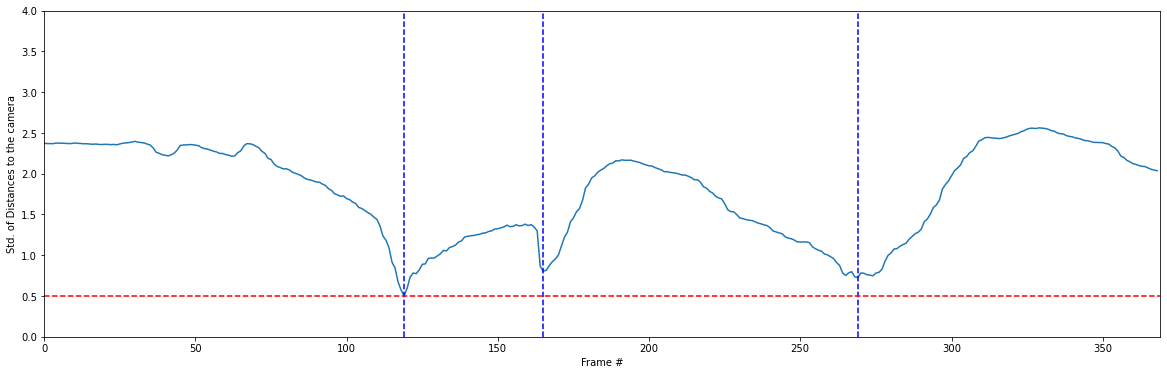

In [15]:
cutoffs = registration.find_cutoffs(std_values, config.target_fps, config.min_std, config.threshold)

plt.figure(figsize=(20, 6))
plt.plot(std_values)

for x in cutoffs:
    plt.axvline(x, c="b", linestyle="--")

plt.axhline(y=0.5, color="r", linestyle="--")
plt.ylim(0, 4)
plt.xlim(0, len(std_values))

plt.xlabel("Frame #")
plt.ylabel("Std. of Distances to the camera")
plt.show()

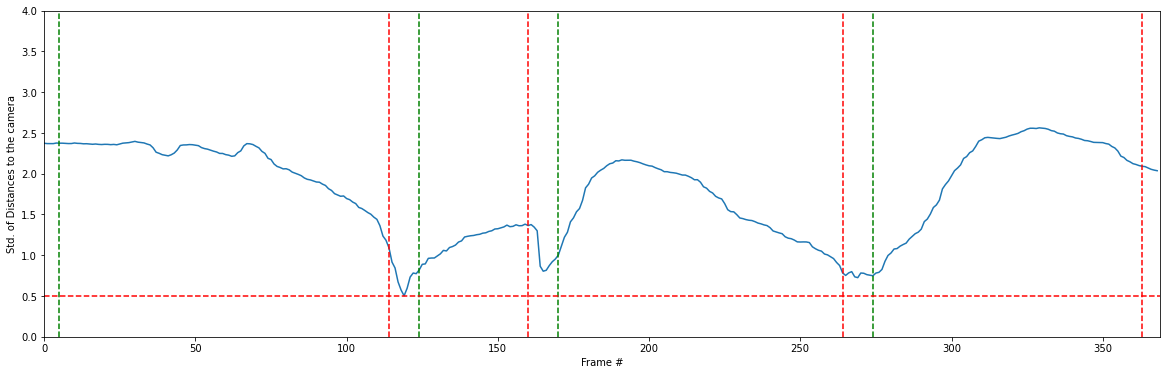

In [16]:
cutoffs = registration.get_cutoff_sequence(std_values, config.target_fps, config.min_std, config.threshold, config.cutoff_margin)

plt.figure(figsize=(20, 6))
plt.plot(std_values)

for si, ei in cutoffs:
    plt.axvline(si, c="g", linestyle="--")
    plt.axvline(ei, c="r", linestyle="--")

plt.axhline(y=0.5, color="r", linestyle="--")
plt.ylim(0, 4)
plt.xlim(0, len(std_values))

plt.xlabel("Frame #")
plt.ylabel("Std. of Distances to the camera")
plt.show()

In [40]:
local_t = [np.identity(4) for _ in range(num_frames)]

for start_c, end_c in cutoffs:
    # first frame registration with FPFH
    source, source_fpfh = registration.compute_fpfh(copy.deepcopy(local_pcds[start_c + 1]), config.voxel_size, down_sample=False)
    target, target_fpfh = registration.compute_fpfh(copy.deepcopy(local_pcds[start_c]), config.voxel_size, down_sample=False)

    reg_result = registration.exec_ransac(source, target, source_fpfh, target_fpfh, n_ransac=4, threshold=0.05)
    reg_result = registration.exec_icp(source, target, 0.05, reg_result.transformation, 200)

    # registration.describe(source, target, reg_result)
    # registration.view(source, target, reg_result.transformation)

    velocity = reg_result.transformation[:3, 3] / (sequence_ts[start_c + 1] - sequence_ts[start_c]) * 1000
    
    local_t[start_c + 1] = reg_result.transformation

    # local_t = [np.identity(4), reg_result.transformation]
    

    for t in tqdm.trange(start_c + 1, end_c - 1):
        start_t, end_t = t, t + 1
        
        imu_slice_df = imu_df[(imu_df.timestamp >= sequence_ts[start_t]) & (imu_df.timestamp <= sequence_ts[end_t])]
        
        # calculate displacement and rotation
        rotation_matrix = np.identity(4)
        translation = np.zeros(3)

        for i in range(len(imu_slice_df)):
            v = imu_slice_df.iloc[i].values
            
            dt = v[7]
            
            # current displacement and rotation
            da = np.degrees([v[j + 4] * dt for j in range(3)])
            
            acceleration = imu_slice_df.iloc[i, [1, 2, 3]].values

            d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
            d = np.dot(rotation_matrix, np.array([*d, 1]))
            
            translation = translation + d[:3]
            velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
            
            rotation_matrix = transform.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
            
        trans_mat = np.identity(4)
        trans_mat[:3, 3] = translation
        trans_mat[:3, :3] = rotation_matrix[:3, :3]
        
        source = copy.deepcopy(local_pcds[end_t])
        target = copy.deepcopy(local_pcds[start_t])
        
        refined_transform = registration.exec_icp(source, target, 0.05, trans_mat, 500).transformation # 200
        
        velocity = refined_transform[:3, 3] * 1e3 / (sequence_ts[end_t] - sequence_ts[start_t])
        
        # local_t.append(refined_transform)
        local_t[end_t] = refined_transform

 31%|███       | 33/107 [00:02<00:04, 15.94it/s]


KeyboardInterrupt: 

In [38]:
local_t = np.array(local_t)

In [39]:
trajectory_t = [np.identity(4) for _ in range(num_frames)]

for start_c, end_c in cutoffs:
    for t in range(start_c + 1, end_c):
        trajectory_t[t] = np.dot(trajectory_t[t - 1], local_t[t])
        
    trajectory_pcd = []

    for t in range(start_c, end_c):
        pcd = copy.deepcopy(local_pcds[t])
        pcd.transform(trajectory_t[t])
        trajectory_pcd.append(pcd)

    trajectory = pointcloud.merge_pcds(trajectory_pcd, config.voxel_size)
    open3d.visualization.draw_geometries([trajectory])